In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
aggregates = pd.read_csv("./data/pubg/aggregate.csv",index_col=0)
deaths = pd.read_csv("./data/pubg/deaths.csv",index_col=0)

In [3]:
# aggregates.head()
# deaths.head()
# aggregates.isnull().any()
# aggregates = aggregates.dropna()
# aggregates.isnull().any()

# deaths.isnull().any()
# deaths.info()
deaths = deaths.dropna()
deaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450331 entries, 6803296 to 2480077
Data columns (total 12 columns):
killed_by            450331 non-null object
killer_name          450331 non-null object
killer_placement     450331 non-null float64
killer_position_x    450331 non-null float64
killer_position_y    450331 non-null float64
map                  450331 non-null object
match_id             450331 non-null object
time                 450331 non-null int64
victim_name          450331 non-null object
victim_placement     450331 non-null float64
victim_position_x    450331 non-null float64
victim_position_y    450331 non-null float64
dtypes: float64(6), int64(1), object(5)
memory usage: 44.7+ MB


In [4]:
# 通过修改数据类型，降低df所占内存大小
aggregates = aggregates.astype({
    "game_size":np.int8,
    "match_id":np.str_,
    "match_mode":np.str_,
    "party_size":np.int8,
    "player_assists": np.int8,
    "player_dbno": np.int8,
    "player_dist_ride": np.float32,
    "player_dist_walk": np.float32,
    "player_dmg": np.int16,
    "player_kills": np.int16,
    "player_name": np.str_,
    "player_survive_time": np.float64,
    "team_id": np.int32,
    "team_placement": np.int8
})

deaths = deaths.astype({
    "killed_by": np.str_,
    "killer_name": np.str_,
    "killer_placement": np.float16,
    "killer_position_x": np.float32,
    "killer_position_y": np.float32,
    "map": np.str_,
    "match_id": np.str_,
    "time": np.int16,
    "victim_placement": np.float16,
    "victim_position_x": np.float32,
    "victim_position_y": np.float32,
})
deaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450331 entries, 6803296 to 2480077
Data columns (total 12 columns):
killed_by            450331 non-null object
killer_name          450331 non-null object
killer_placement     450331 non-null float16
killer_position_x    450331 non-null float32
killer_position_y    450331 non-null float32
map                  450331 non-null object
match_id             450331 non-null object
time                 450331 non-null int16
victim_name          450331 non-null object
victim_placement     450331 non-null float16
victim_position_x    450331 non-null float32
victim_position_y    450331 non-null float32
dtypes: float16(2), float32(4), int16(1), object(5)
memory usage: 30.1+ MB


In [5]:
# 1. 玩家的存活时间超过3个小时的
agg1 = aggregates[(aggregates['player_survive_time']/60/60) > 3]
# aggregates.drop(agg1.index,inplace=True)

# 2. 如果游戏总人数超过50人，并且击杀比例超过40%
gameSizeOver50 = aggregates['game_size'] > 50
killRateOver40 = (aggregates['player_kills']/aggregates['game_size']) > 0.4
agg2 = aggregates[(gameSizeOver50) & (killRateOver40)]
aggregates.drop(agg2.index,inplace=True)

# 3. 移动总距离小于1，但是还杀人了
moveDistanceLess1 = (aggregates['player_dist_ride'] + aggregates['player_dist_walk']) < 1
hasKillOver1 = aggregates['player_kills'] > 1
aggregates[(moveDistanceLess1) & (hasKillOver1)]

# 4. 击杀的人的距离和被击杀的人的距离中出现了0
statement = (deaths['killer_position_x'] == 0) | (deaths['killer_position_y'] == 0) | (deaths['victim_position_y'] == 0) | (deaths['victim_position_x'] == 0)
agg4 = deaths[statement]
deaths.drop(agg4.index,inplace=True)

In [6]:
# 新增是否吃鸡特性
aggregates['win'] = aggregates['team_placement'].apply(lambda x:1 if x == 1 else 0)
deaths['win'] = deaths['killer_placement'].apply(lambda x: 1 if x == 1 else 0)

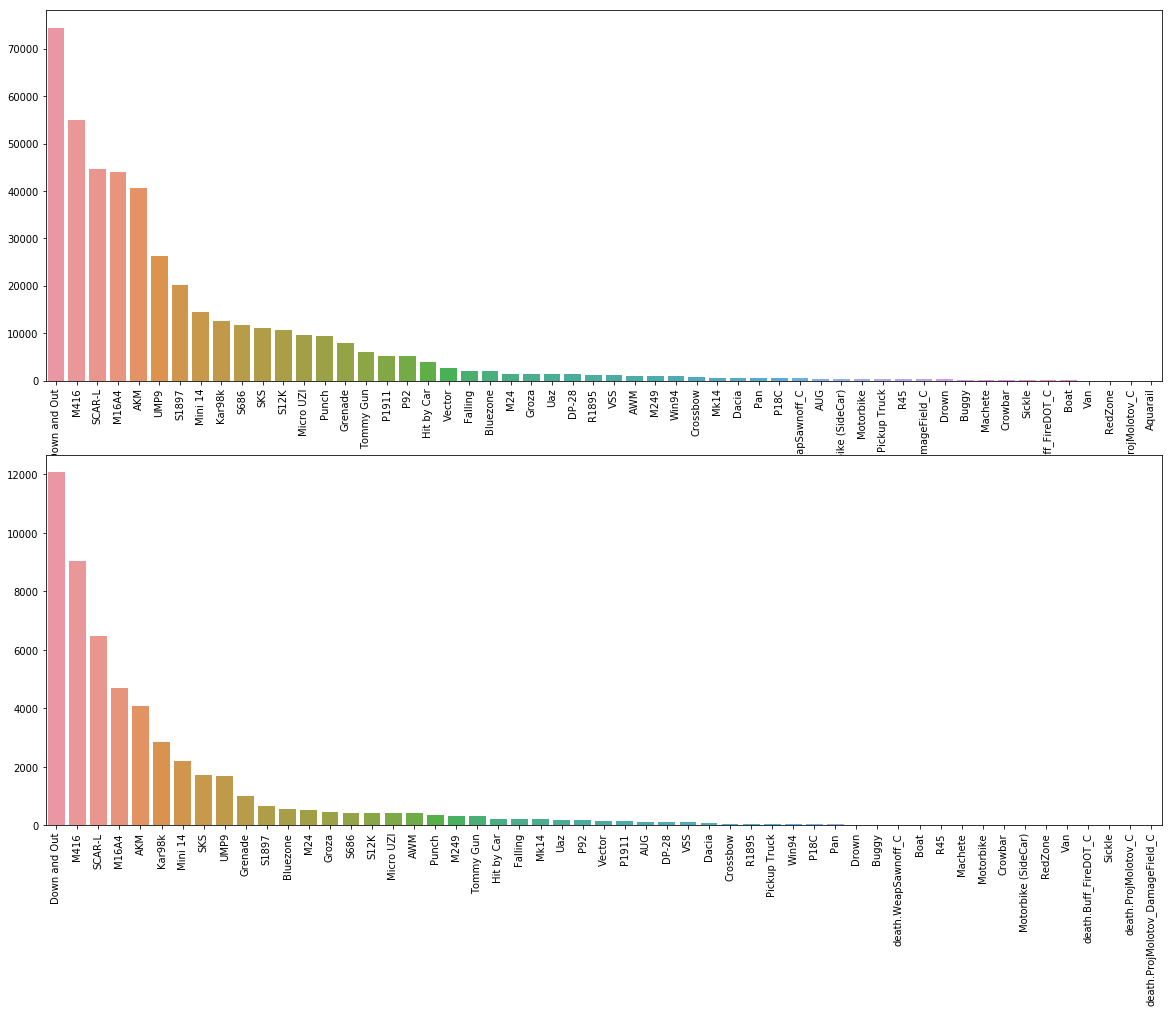

In [7]:
# 分析武器和吃鸡的关系
# 1. 看下什么武器杀人最多
fig,axes = plt.subplots(2,1)
fig.set_figwidth(20)
fig.set_figheight(15)
ax1 = axes[0]
weapons1 = deaths['killed_by'].value_counts()
sns.barplot(x=weapons1.index,y=weapons1.values,ax=ax1)
temp = ax1.set_xticklabels(weapons1.index,rotation=90)
# 2. 看下什么武器吃鸡最多
ax2 = axes[1]
weapons2 = deaths[deaths['win'] == 1]['killed_by'].value_counts()
sns.barplot(x=weapons2.index,y=weapons2.values,ax=ax2)
temp = ax2.set_xticklabels(weapons2.index,rotation=90)

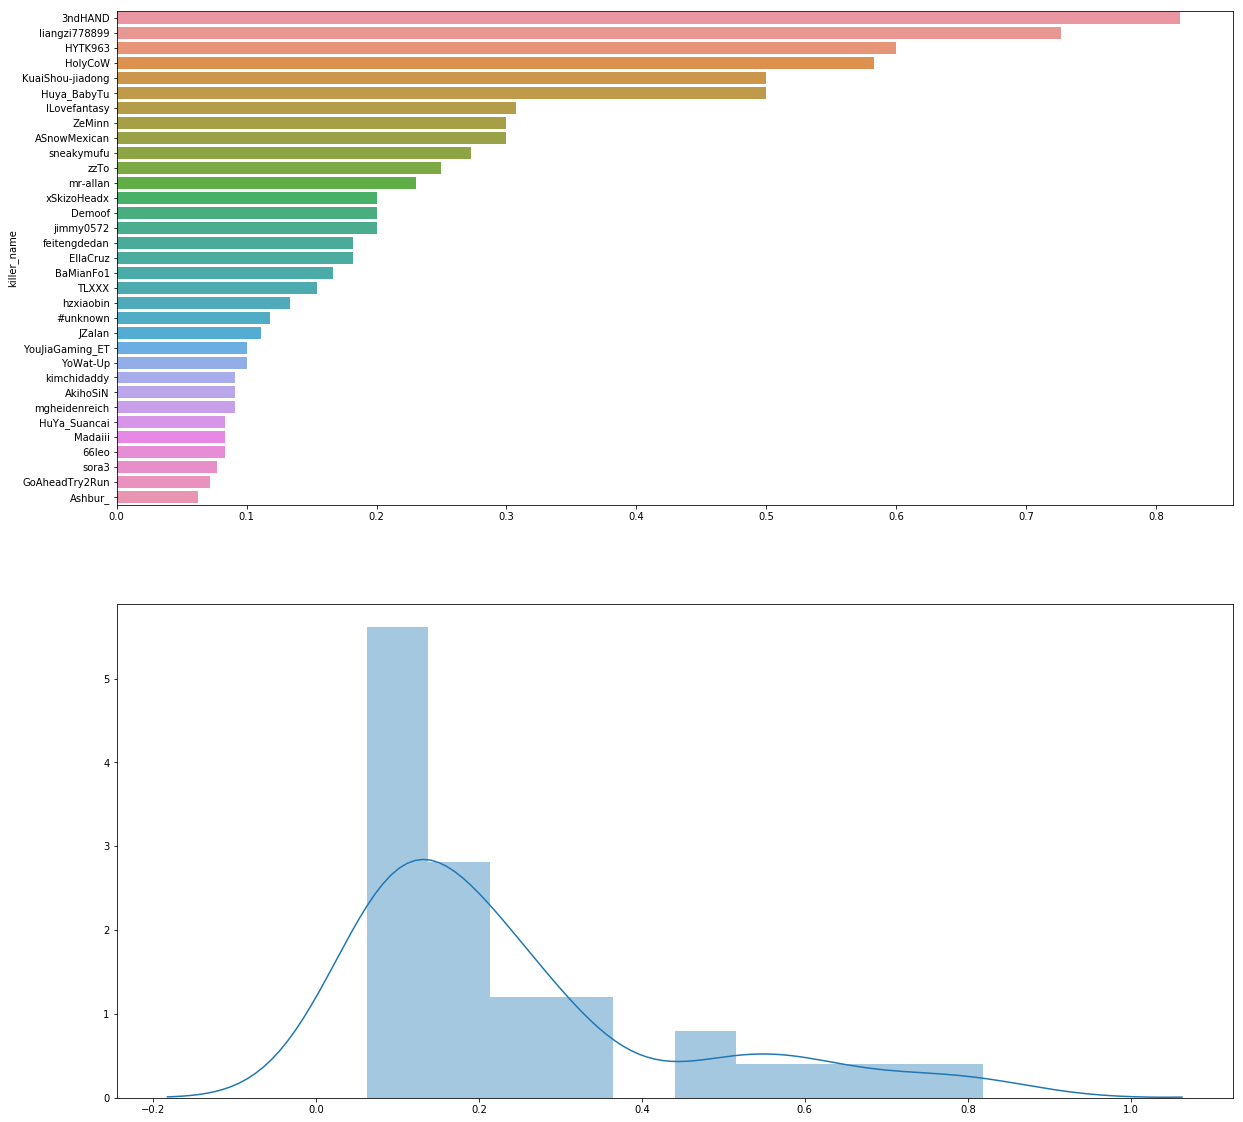

In [8]:
# 分析吃玩家的吃鸡概率
player_group = deaths.groupby("killer_name")
match_counts = player_group.count()['killed_by'].rename("match_count")
win_counts = player_group.sum()['win'].rename("win_count")
match_win_datas = pd.merge(match_counts,win_counts,left_index=True,right_index=True)
match_win_datas = match_win_datas[match_win_datas['match_count']>=10]
win_rates = match_win_datas['win_count']/match_win_datas['match_count']
win_rates = win_rates[win_rates>0]
win_rates = win_rates.sort_values(ascending=False)

fig,axes = plt.subplots(2,1)
fig.set_figwidth(20)
fig.set_figheight(20)
ax1 = axes[0]
sns.barplot(y=win_rates.index,x=win_rates.values,ax=ax1)

ax2 = axes[1]
sns.distplot(win_rates.values,ax=ax2,bins=10)

D:\ProgramApp\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


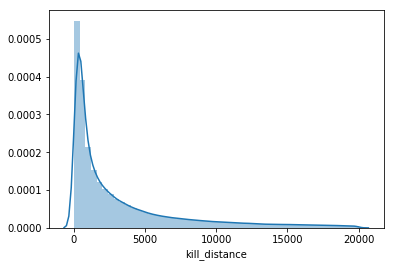

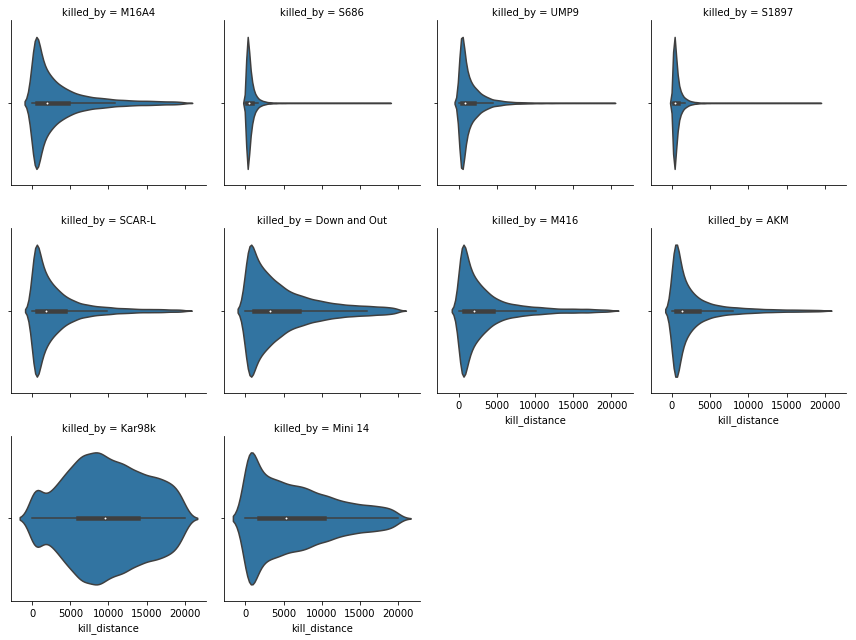

In [9]:
# 查看击杀距离的分布
deaths['kill_distance'] = np.sqrt(
    np.square(deaths['victim_position_x'] - deaths['killer_position_x']) + 
    np.square(deaths['victim_position_y'] - deaths['killer_position_y'])
)
deaths_distance = deaths[deaths['kill_distance'] < 20000]
sns.distplot(deaths_distance['kill_distance'])
# 查看各个枪的击杀距离的分布

weapon_distance = deaths_distance[deaths_distance['killed_by'].isin(weapons1.index[:10])][['killed_by','kill_distance']]
fg = sns.FacetGrid(weapon_distance,col="killed_by",col_wrap=4)
fg.map(sns.violinplot,"kill_distance")

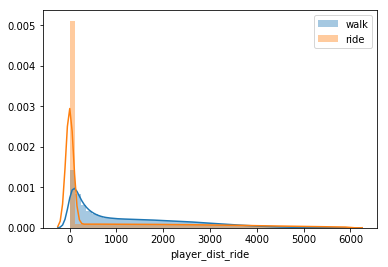

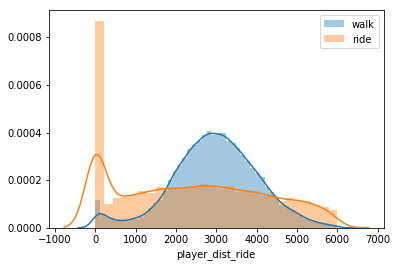

In [10]:
# 查看移动距离（行驶距离+步行距离）的分布
walk_aggregates = aggregates[aggregates['player_dist_walk']<6000]
sns.distplot(walk_aggregates['player_dist_walk'])

ride_aggregates = aggregates[aggregates['player_dist_ride']<6000]
ax = sns.distplot(ride_aggregates['player_dist_ride'])
ax.legend(['walk','ride'])

plt.figure()
sns.distplot(walk_aggregates[walk_aggregates['win'] == 1]['player_dist_walk'])
ax = sns.distplot(ride_aggregates[ride_aggregates['win'] == 1]['player_dist_ride'])
ax.legend(['walk','ride'])